# Практическая работа №3: Частотный анализ полиномиальных приближений

Выполнили студенты гр. 0303 Смирнов Артем и Переверза Михаил. Вариант №2.

## Цель работы

Провести анализ частотных характеристик известных формул полиномиального сглаживания временных рядов.

## Основные теоретические положения

Принцип работы нерекурсивного цифрового фильтра:

$$ y_k = \sum_{n = -N}^N{}h_nS(k-n)$$

где S - входное воздействие, y – результат фильтрации, h – коэффициенты
фильтра.

Нерекурсивные фильтры требуют большего числа вычислений, однако при определенных условиях они позволяют получить линейную фазовую характеристику цифрового фильтра и обеспечивают устойчивость работы.

Чтобы обеспечить хорошее подавление ошибок без искажения сигнала
необходимо чтобы АЧХ фильтра обладала следующими параметрами:
- гладкая и близкая к 1 в полосе пропускания (сигнал не должен
искажаться);
- должна иметь маленькую переходную зону (область между полосой
пропускания и полосой подавления);
- гладкая и близкая к 0 в полосе подавления.

Чтобы добиться высоких характеристик, необходимо использовать фильтр с
большим количеством элементов. Для цифровых фильтров это порядок фильтра – количество элементов задержки. При использовании меньшего числа элементов в АЧХ появляются искажения. Так, усечение числа элементов при разложении в частотный ряд ведет к искажениям во временной области, а усечения во временной области приводят к искажениям в частотной – это явление называется явлением Гиббса.
- крутизна перепадов "размывается", т.к. она не может быть больше, чем крутизна последней сохраненной гармоники ряда;
- по обе стороны "размытых" перепадов появляются выбросы и затухающие колебания с частотой, близкой к частоте первого отброшенного члена ряда.

Чтобы уменьшить искажения необходимо скорректировать коэффициенты фильтра. Для этого используют весовые функции. Весовая функция уменьшает вклад коэффициентов более высокого порядка.

Основной принцип оконного метода проектирования состоит в обрезании
идеальной импульсной характеристики одним из окон конечной длины.

## Постановка задачи

Получить формулы для передаточных функций нерекурсивных фильтров, соответствующих полиномиальному сглаживанию дискретного сигнала для полиномов различного порядка и построить графики $\tilde{H}(f)$. Проинтерпретировать частотные свойства передаточных функций. Провести сопоставительный анализ частотных характеристик передаточных функций для различных степеней полиномов.

## Выполнение работы

Для начала, ипортируем необходимые библиотеки:

In [1]:
# установка зависимости, которая отвечает за выбор правильного окончания
!pip install pytils

In [2]:
# импорт зависимостей

from collections.abc import Callable, Iterable, Sequence
from dataclasses import dataclass
from functools import partial


import matplotlib.pyplot as plt
import numpy as np
from pytils import numeral


Определим функцию для отрисовки графиков:

In [3]:
@dataclass
class Graphic:
    """Конкретный график"""

    plot_function: Callable
    """Функция отрисовки"""
    y_function: Callable
    """Функция генерации y от x"""
    label: str = ''
    """label для графика"""
    x: Sequence | None = None
    """x для конкретного графика"""

    def plot(self, x: Sequence, color: str, **kwargs):
        """Отрисовка конкретного графика"""

        x = self.x if self.x is not None else x
        y = self.y_function(x)

        # Выбор названия кварга, отвечающего за цвет графика
        # оно меняется, в зависимости от функции отрисовки в pyplot
        match self.plot_function:
            case plt.stem:
                color_arg = 'linefmt'
            case _:
                color_arg = 'color'

        kwargs.update({color_arg: color})
        self.plot_function(x, y, label=self.label, **kwargs)


@dataclass
class GraphicsBlock:
    """Блок графиков, отображаемый на одной плитке"""

    graphics: list[Graphic]
    """Отображаемые блоки"""
    x: Sequence | None = None
    """x для блока графиков"""
    x_label: str = ''
    """Подпись к графику по x"""
    y_label: str = ''
    """Подпись к графику по x"""


def print_graphic(graphic_blocs: Iterable[GraphicsBlock]):
    """Отображение нескольких блоков графиков"""

    plt.figure(figsize=(20, 10))
    colors = ['blue', 'red', 'green', 'pink', 'orange']

    # перебор "прилиток" графиков
    block: GraphicsBlock
    for i, block in enumerate(graphic_blocs, start=1):
        plt.subplot(len(graphic_blocs), 1, i)

        # перебор конкретных графиов в плитке
        graphic: Graphic
        for j, graphic in enumerate(block.graphics):
            graphic.plot(x=block.x, color=colors[j])

        # задание оформления блоку
        plt.legend()
        plt.xlabel(block.x_label)
        plt.ylabel(block.y_label)
        plt.grid()
    plt.show()


def get_dot_name(dot_count: int) -> str:
    """Получение человекочитаемого значения кол-ва точек"""

    return numeral.get_plural(dot_count, 'точка, точки, точек')

### Задание 1. Вывод формул для передаточной функции нерекурсивного фильтра, соответствующего сглаживанию прямой линией по 3, 5, 7 и 9 точкам.

Не умаляя общности здесь и далее предполагаем, что частота дискретизации равна 1 и равномерна.

Имеем дискретизированный входной $s(t)$ и выходной $y(t)=A+Bt$ сигналы, среднюю точку полагаем  $k = 0$, приближение (в смысле МНК) прямой линией по пяти точкам:

$$F(A,B)=\sum^{2}_{k=-2}(s_k-y_k)^2=\sum^{2}_{k=-2}(s_k-A-Bk)^2 \Rightarrow min$$

Система нормальных уравненией выглядит следующим образом:

$$\begin{cases}5A+0B=\sum^{k=2}_{k=-2}s_k\\0A+10B=\sum^{k=2}_{k=-2}ks_k\end{cases}$$

Решая систему уравнений получаем:
$$y_0=A=\frac{1}{5}\sum_{k=-2}^{k=2}s_k=\frac{1}{5}(s_{-2}+s_{-1}+s_0+s_1+s_2)$$

В общем случае $y_n$ присваивается среднее из пяти отсчетов:

$$y_n=\frac{1}{5}\sum_{k=n-2}^{k=n+2}s_k=\frac{1}{5}(s_{n-2}+s_{n-1}+s_n+s_{n+1}+s_{n+2})$$

Предположим, что дискретный ряд имеет отсчеты $s_n=e^{i\omega n}$, тогда:

$$y_n=\frac{1}{5}(e^{-2i\omega}+e^{-i\omega}+1+e^{i\omega}+e^{2i\omega})e^{i\omega n}=H(\omega)e^{i\omega n}$$

Отсюда получаем передоточную функцию:

$$H(\omega)=\frac{1}{5}(e^{-2i\omega}+e^{-i\omega}+1+e^{i\omega}+e^{2i\omega})$$

Можем преобразовать с помощью функции Эйлера, перейдем к выражению:

$$H(\omega)=0.2[1+2cos(\omega)+2cos(2\omega)]$$

Поскольку $(e^{-2i\omega}+e^{-i\omega}+1+e^{i\omega}+e^{2i\omega})$ есть геометрическая прогрессия со знаменателем $e^{i n}$, воспользуемся формулой суммы геометрической прогрессии, получим:

$$H(\omega)=\frac{e^{i\frac{5\omega}{2}}-e^{-i\frac{5\omega}{2}}}{5(e^{i\frac{\omega}{2}}-e^{-i\frac{\omega}{2}})}=\frac{sin(\frac{5\omega}{2})}{5sin(\frac{\omega}{2})}$$

$H(\omega)$ - периодическая функция с периодом $2\pi$. Частота рассматриваемого дискретного сигнала не должна превышать $\pi$, поэтому обычно рассматривается интервал $(-\pi, \pi)$ для круговой частоты $\omega$, или $(-0.5,0.5)$ для циклической частоты $f$:

$$H(\omega)=H(2\pi f)=\tilde H(f)$$

В общем случае при приближении полиномом нулевого порядка прямой линией для $2m+1$ точек имеем:

$$H(\omega)=\frac{1}{2m+1}[1+2cos(\omega)+2cos(2\omega)+...+2cos(m\omega)]$$

или

$$H(\omega)=\frac{sin(\frac{(2m+1)\omega}{2})}{(2m+1)sin(\frac{\omega}{2})}$$

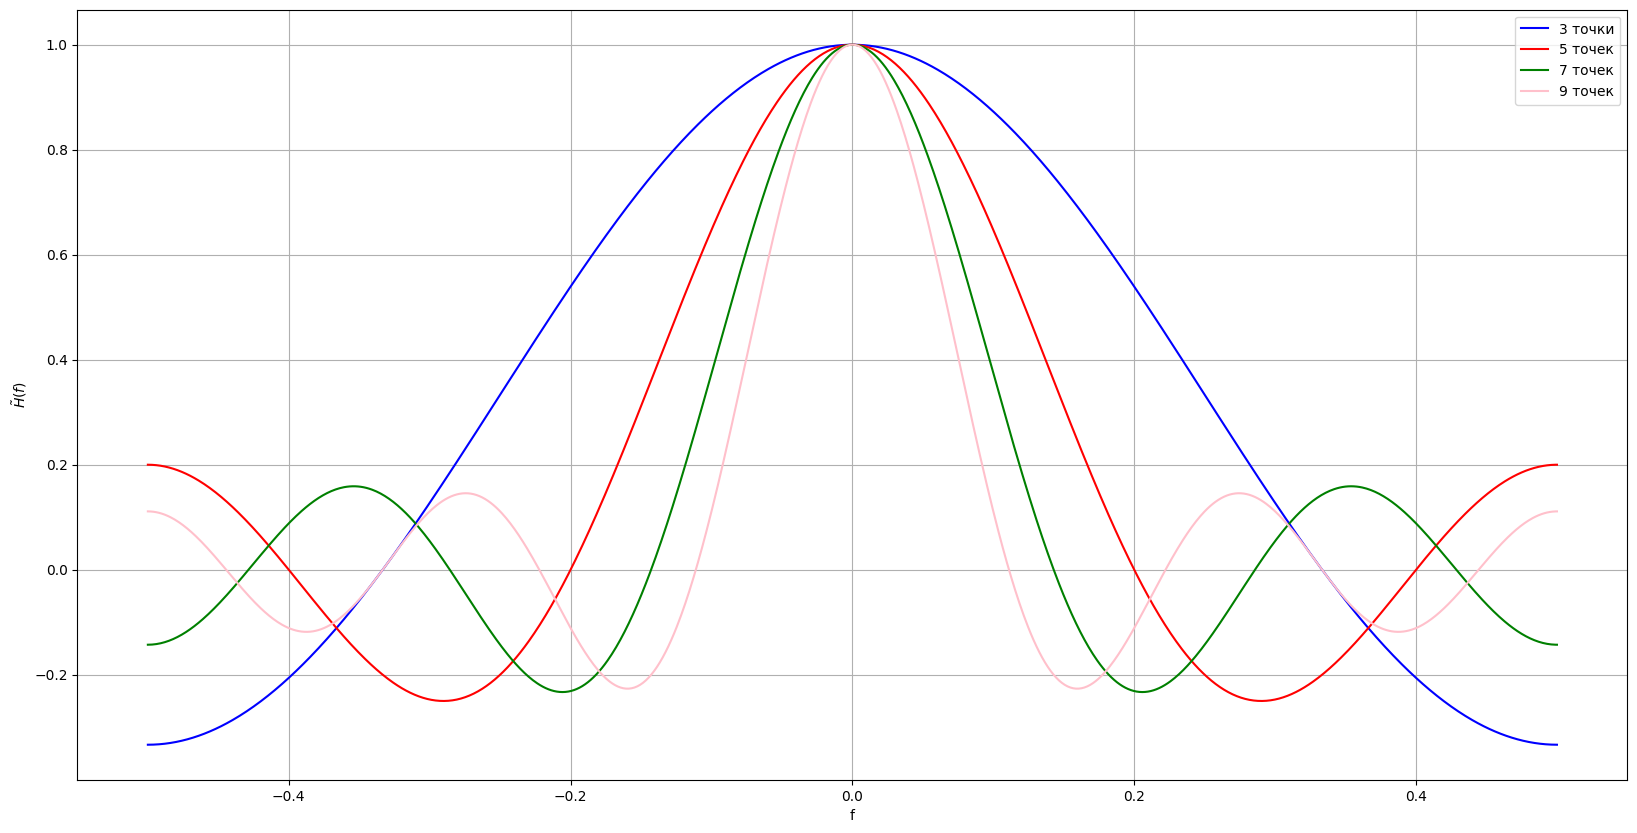

In [4]:
# общая функция для вычисления H(w) в данном задании
# принимает f, по которому будет вычисляться w и m - кол-во точек
def h_task_1(f, m):
    w = f * 2 * np.pi
    numerator = np.sin((2 * m + 1) * w / 2)   # числитель формулы
    denumerator = (2 * m + 1) * np.sin(w / 2) # знаменатель формулы

    return numerator / denumerator

x_task_1 = np.linspace(-0.5, 0.5, 1000)



print_graphic(
    graphic_blocs=[
        GraphicsBlock(
            graphics=[
                Graphic(
                    plot_function=plt.plot,
                    x=x_task_1,
                    y_function=partial(h_task_1, m=m),
                    label=get_dot_name(2 * m + 1),
                )
                for m in range(1, 5)
            ],
            x_label='f',
            y_label=r'$\tilde H(f)$',
        ),
    ],
)

Как видим, графики симметричны относительно нуля (здесь и далее), чего и следовало ожидать. В конце окна начинают появляться колебательные элементы (так называемое явление Гиббса), крутизна спада возрастает по мере увеличения числа точек, в то же время, чем больше количество точек, тем меньше амплитуда колебательных изменений. В окрестности нулевой частоты практически не подавляется входной сигнал, т.е. полоса пропускания сигнала без искажений очень узкая.

### Задание 2. Вывод формул для передаточной функции нерекурсивного фильтра, соответствующего сглаживанию полиномом второй степени по 7, 9, 11 и 13 точкам.

При сглаживании полиномом второй степени $y(t)=A+Bt+Ct^2$, приближение (в смысле МНК) прямой линией по семи точкам:

$$F(A,B,C)=\sum^{3}_{k=-3}(s_k-y_k)^2=\sum^{3}_{k=-3}(s_k-A-Bk-Ck^2)^2 \Rightarrow min$$

Аналогично необходимо найти коэффициенты A, B и C из системы из трех уранений с тремя неизвестными, но интересовать нас будет, как и ранее, только A.


$$\begin{cases}
7A + 0B + 10C = \sum^{k=3}_{k=-3}s_k \\
0A + 28B + 0C = \sum^{k=3}_{k=-3}ks_k \\
28A + 0B + 196C = \sum^{k=3}_{k=-3}k^2s_k
\end{cases}$$

Получаем, что для 7 точек справедливо:

$$y_n=\frac{1}{21}(-2s_{n-3}+3s_{n-2}+6s_{n-1}+7s_{n}+6s_{n+1}+3s_{n+2}-2s_{n+3})$$

Взяв входной сигнал $s_n=e^{i\omega n}$, получаем передаточную функцию:

$$H(\omega)=\frac{1}{21}[7+12cos(\omega)+6cos(2\omega)-4cos(3\omega)]$$

Аналогично находим передаточные функции для 9, 11 и 13 точек.

Для 9-ти точек:

$$y_n = \frac{1}{231}(-21s_{n-4}+14s_{n-3}+39s_{n-2}+54s_{n-1}+59s_{n}+54s_{n+1}+39s_{n+2}+14s_{n+3}-21s_{n+4})$$

$$H(\omega)=\frac{1}{231}[59+108cos(\omega)+78cos(2\omega)+28cos(3\omega)-42cos(4\omega)]$$

Для 11-ти точек:

$$y_n=\frac{1}{429}(-36s_{n-5}+9s_{n-4}+44s_{n-3}+69s_{n-2}+84s_{n-1}+89s_{n}+84s_{n+1}+69s_{n+2}+44s_{n+3}+9s_{n+4}-36s_{n+5})$$

$$H(\omega)=\frac{1}{429}[89+168cos(\omega)+138cos(2\omega)+88cos(3\omega)+18cos(4\omega)-72cos(5\omega)]$$

Для 13-ти точек:

$$y_n=\frac{1}{143}(-11s_{n-6}+9s_{n-4}+16s_{n-3}+21s_{n-2}+24s_{n-1}+25s_{n}+24s_{n+1}+21s_{n+2}+16s_{n+3}+9s_{n+4}-11s_{n+6})$$

$$H(\omega)=\frac{1}{143}[25+48cos(\omega)+42cos(2\omega)+32cos(3\omega)+18cos(4\omega)-22cos(6\omega)]$$

In [ ]:
# вычисление w по заданному f
def w_by_f(f):
    return f * 2 * np.pi


# общая фунцкия, которая по заданным коэффициентам считает значение H(w)
def h_by_coefficients_task_2(f, coefficients: list[int], denominator):
    w = w_by_f(f)
    res = coefficients[0]
    for i, coeff in enumerate(coefficients[1:], start=1):
        res += coeff * np.cos(i * w)

    return res / denominator


f_task_2 = np.linspace(-0.5, 0.5, 1000)


print_graphic(
    graphic_blocs=[
        GraphicsBlock(
            graphics=[
                Graphic(
                    plot_function=plt.plot,
                    x=f_task_2,
                    # H(w) для г точек (задаются коэффициенты, посчитанные выше)
                    y_function=partial(h_by_coefficients_task_2, coefficients=(7, 12, 6, -4), denominator=21),
                    label=get_dot_name(7),
                ),
                Graphic(
                    plot_function=plt.plot,
                    x=f_task_2,
                    # H(w) для 9 точек (задаются коэффициенты, посчитанные выше)
                    y_function=partial(h_by_coefficients_task_2, coefficients=(59, 108, 78, 28, -42), denominator=231),
                    label=get_dot_name(9),
                ),
                Graphic(
                    plot_function=plt.plot,
                    x=f_task_2,
                    # H(w) для 11 точек (задаются коэффициенты, посчитанные выше)
                    y_function=partial(h_by_coefficients_task_2, coefficients=(89, 168, 138, 88, 18, -72), denominator=429),
                    label=get_dot_name(11),
                ),
                Graphic(
                    plot_function=plt.plot,
                    x=f_task_2,
                    # H(w) для 13 точек (задаются коэффициенты, посчитанные выше)
                    y_function=partial(h_by_coefficients_task_2, coefficients=(25, 48, 42, 32, 18, -22), denominator=143),
                    label=get_dot_name(13),
                ),
            ],
            x_label='f',
            y_label=r'$\tilde H(f)$',
        ),
    ],
)


Как видим, чем больше точек используется при сглаживании, тем выше крутизна графика передаточной функции. Степень касания в окрестности нуля возрастает с ростом количества точек, зона пропуска сигнала без искажений шире, чем при линейной аппроксимации.

### Задание 3. Вывод формул для передаточной функции нерекурсивного фильтра, соответствующего сглаживанию полиномом четвёртой степени по 9, 11, 13 и 15 точкам.

При сглаживании полиномом второй степени $y(t)=A+Bt+Ct^2+Dt^3+Et^4$, приближение (в смысле МНК) прямой линией по пятнадцати точкам:

$$F(A,B,C,D,E)=\sum^{7}_{k=-7}(s_k-y_k)^2=\sum^{7}_{k=-7}(s_k-A-Bk-Ck^2-Dk^3-Ek^4)^2 \Rightarrow min$$

Аналогично предыдущим пунктам можно получить следующую систему нормальных уравнений:

$$\begin{cases}
15A + 0B + 280C + 0D + 9352E = \sum^{k=7}_{k=-7}s_k \\
0A + 280B + 0C + 9352D + 0E = \sum^{k=7}_{k=-7}ks_k \\
280A + 0B + 9352C + 0D + 369640E = \sum^{k=7}_{k=-7}k^2s_k \\
0A + 9352B + 0C + 369640D + 0E = \sum^{k=7}_{k=-7}k^3s_k \\
9352A + 0B + 369640C + 0D + 15814792E = \sum^{k=7}_{k=-7}k^4s_k
\end{cases}$$

Получаем, что для 15-ти точек справедливо:

$$y_n=\frac{1}{46189}(2145s_{n-7}-2860s_{n-6}-2937s_{n-5}-165s_{n-4}+3755s_{n-3}+7500s_{n-2}+10125s_{n-1}+11063s_{n}+10125s_{n+1}+7500s_{n+2}+3755s_{n+3}-165s_{n+4}-2937s_{n+5}-2860s_{n+6}+2145s_{n+7})$$

$$H(\omega) = \frac{1}{46189}\big[11063 + 20250cos(\omega) + 15000cos(2\omega) + 7510cos(3\omega) - 330cos(4\omega) - 5874cos(5\omega) - 5720cos(6\omega) + 4290cos(7\omega)\big]$$

Похожим образом выводим передаточные функции для 9, 11 и 13 точек.

Для 9-ти точек:

$$y_n=\frac{1}{429}(15s_{n-4}-55s_{n-3}+30s_{n-2}+135s_{n-1}+179s_{n}+135s_{n+1}+30s_{n+2}-55s_{n+3}+15s_{n+4})$$

$$H(\omega) = \frac{1}{429}\big[179 + 270cos(\omega) + 60cos(2\omega) - 110cos(3\omega) + 30cos(4\omega)\big]$$
    
Для 11-ти точек:

$$y_n=\frac{1}{429}(18s_{n-5}-45s_{n-4}-10s_{n-3}+60s_{n-2}+120s_{n-1}+143s_{n}+120s_{n+1}+60s_{n+2}-10s_{n+3}-45s_{n+4}+18s_{n+5})$$

$$H(\omega) = \frac{1}{429}\big[143 + 240cos(\omega) + 120 cos(2\omega) - 20 cos(3\omega) - 90cos(4\omega) + 36cos(5\omega)\big]$$
    
Для 13-ти точек:
    
$$y_n=\frac{1}{2431}(110s_{n-6}-198s_{n-5}-135s_{n-4}+110s_{n-3}+390s_{n-2}+600s_{n-1}+677s_{n}+600s_{n+1}+390s_{n+2}+110s_{n+3}-135s_{n+4}-198s_{n+5}+110s_{n+6})$$

$$H(\omega) = \frac{1}{2431}\big[677 + 1200cos(\omega) + 780cos(2\omega) + 220 cos(3\omega) - 270cos(4\omega) - 396cos(5\omega) + 220cos(6\omega)\big]$$

In [ ]:
f_task_3 = np.linspace(-0.5, 0.5, 1000)

print_graphic(
    graphic_blocs=[
        GraphicsBlock(
            graphics=[
                Graphic(
                    plot_function=plt.plot,
                    x=f_task_2,
                    # H(w) для 9 точек (задаются коэффициенты, посчитанные выше)
                    y_function=partial(h_by_coefficients_task_2, coefficients=(179, 270, 60, -110, 30), denominator=429),
                    label=get_dot_name(9),
                ),
                Graphic(
                    plot_function=plt.plot,
                    x=f_task_2,
                    # H(w) для 11 точек (задаются коэффициенты, посчитанные выше)
                    y_function=partial(h_by_coefficients_task_2, coefficients=(143, 240, 120, -20, -90, 36), denominator=429),
                    label=get_dot_name(11),
                ),
                Graphic(
                    plot_function=plt.plot,
                    x=f_task_2,
                    # H(w) для 13 точек (задаются коэффициенты, посчитанные выше)
                    y_function=partial(h_by_coefficients_task_2, coefficients=(677, 1200, 780, 220, -270, -396, 220), denominator=2431),
                    label=get_dot_name(13),
                ),
                Graphic(
                    plot_function=plt.plot,
                    x=f_task_2,
                    # H(w) для 15 точек (задаются коэффициенты, посчитанные выше)
                    y_function=partial(h_by_coefficients_task_2, coefficients=(11063, 20250, 15000, 7510, -330, -5874, -5720, 4290), denominator=46189),
                    label=get_dot_name(15),
                ),
            ],
            x_label='f',
            y_label=r'$\tilde H(f)$',
        ),
    ],
)

Как видим, сохраняется та же самая система поведения функций. Чем больше используется точек, тем более крутой получается график, а степень касания к единице еще выше, чем у приближения полиномом второй степени.

### Задание 4. Вывод формул для передаточной функции нерекурсивного фильтра, соответствующего сглаживанию по формулам Спенсера по 15 и 21 точкам.

Большинство формул сглаживания, использующих метод наименьших квадратов, сохраняют точное значение на нулевой частоте, но, вообще говоря, уменьшают величину любой более высокой частоты, которая может содержаться в сглаживаемой функции.

Наиболее известными из давно применяющихся формул сглаживания являются 15-точечная и 21-точечная формулы Спенсера:

15-точечная:

$$y_n = \frac{1}{320}(-3s_{n-7} - 6s_{n-6} - 5s_{n-5} + 3s_{n-4} + 21s_{n-3} + 46s_{n-2} + 67s_{n-1} + 74s_{n} + 67s_{n+1} + 46s_{n+2} + 21s_{n+3} + 3s_{n+4} - 5s_{n+6} - 6s_{n+6} - 3s_{n+7})$$

Передаточная функция для нее:

$$H(\omega)=\frac{1}{320}\big[74 + 134cos(\omega)+92cos(2\omega)+42cos(3\omega)+6cos(4\omega)-10cos(5\omega)-12cos(6\omega)-6cos(7\omega)\big]$$

21-точечная:
$$y_n = \frac{1}{350}(-s_{n-10} - 3s_{n-9} - 5s_{n-8} - 5s_{n-7} - 2s_{n-6} + 6s_{n-5} + 18s_{n-4} + 33s_{n-3} + 47s_{n-2} + 57s_{n-1} + 60s_{n} + 57s_{n+1} + 47s_{n+2} + 33s_{n+3} + 18s_{n+4} + 6s_{n+5} - 2s_{n+6} - 5s_{n+7} - 5s_{n+8} - 3s_{n+9} -s_{n+10})$$

Передаточная функция для нее:

$$H(\omega)=\frac{1}{350}\big[60 + 114cos(\omega)+94cos(2\omega)+66cos(3\omega)+36cos(4\omega)+12cos(5\omega)-4cos(6\omega)-10cos(7\omega)-10cos(8\omega)-6cos(9\omega)-2cos(10\omega)\big]$$

In [ ]:
f_task_4 = np.linspace(-0.5, 0.5, 1000)

print_graphic(
    graphic_blocs=[
        GraphicsBlock(
            graphics=[
                Graphic(
                    plot_function=plt.plot,
                    x=f_task_2,
                    # H(w) для 15 точек (задаются коэффициенты, посчитанные выше)
                    y_function=partial(h_by_coefficients_task_2, coefficients=(74, 134, 92, 42, 6, -10, -12, -6), denominator=320),
                    label=get_dot_name(15),
                ),
                Graphic(
                    plot_function=plt.plot,
                    x=f_task_2,
                    # H(w) для 21 точки (задаются коэффициенты, посчитанные выше)
                    y_function=partial(h_by_coefficients_task_2, coefficients=(60, 114, 94, 66, 36, 12, -4, -10, -10, -6, -2), denominator=350),
                    label=get_dot_name(21),
                ),
            ],
            x_label='f',
            y_label=r'$\tilde H(f)$',
        ),
    ],
)

Как видим, крутизна спада достаточно высокая, степень колебания очень мала в сравнении с результатами, полученными ранее. Эти две формулы отличаются полосой пропускания частот в процессе фильтрации (сглаживания). Как и следовало ожидать из общих представлений, чем длиннее формула, тем более узкую полосу пропускания частот она обеспечивает. Однако, эти кривые не являются достаточно информативными, так как значения на высоких частотах очень малы. Поэтому лучше наносить логарифмы чисел $H(\omega)$.

### Задание 5. Пострение графиков из предыдущих пунктов в логарифмической шкале (Дб).

Для лучшей информативности графиков построим их в логарифмической шкале, используя понятие *децибелы (десятые доли бела)*, сокращенно обозначаемые Дб и определяемые как:

$$20lg\Big(\frac{|y_n|}{|s_n|}\Big) = Дб$$

К примеру, значение в -20Дб, обозначает подавление входного сигнала в 10 раз.

In [ ]:
# вычисления в логарифмической шкале
def h_log(h, base_h: Callable):
    return 20 * np.log10(np.abs(base_h(np.array([i if i != 0 else 0.001 for i in h]))))


f_task_5 = np.linspace(-0.5, 0.5, 2000)


Передаточная функция из первого пункта:

In [ ]:
# Передаточная функция из первого пункта


print_graphic(
    graphic_blocs=[
        GraphicsBlock(
            graphics=[
                Graphic(
                    plot_function=plt.plot,
                    x=f_task_5,
                    y_function=partial(
                        h_log,
                        base_h=partial(
                            h_task_1,
                            m=m,
                        ),
                    ),
                    label=get_dot_name(2 * m + 1),
                )
                for m in range(1, 5)
            ],
            x_label='f',
            y_label=r'$\tilde H(f)$',
        ),
    ],
)

Передаточная функция из второго пункта:

In [ ]:
# Передаточная функция из второго пункта

# коэффициенты для 7, 9, 11, 13 точек соответственно
coefficients = [
    ((7, 12, 6, -4), 21),
    ((59, 108, 78, 28, -42), 231),
    ((89, 168, 138, 88, 18, -72), 429),
    ((25, 48, 42, 32, 18, -22), 143),
]

print_graphic(
    graphic_blocs=[
        GraphicsBlock(
            graphics=[
                Graphic(
                    plot_function=plt.plot,
                    x=f_task_5,
                    y_function=partial(
                        h_log,
                        base_h=partial(
                            h_by_coefficients_task_2,
                            coefficients=coefficients[i][0],
                            denominator=coefficients[i][1],
                        ),
                    ),
                    label=get_dot_name(dot_count),
                )
                # выбор кол-ва точек от 7 до 13 с шагом 2
                for i, dot_count in enumerate(range(7, 14, 2))
            ],
            x_label='f',
            y_label=r'$\tilde H(f)$',
        ),
    ],
)

Передаточная функция из третьего пункта:

In [ ]:
# Передаточная функция из третьего пункта

# коэффициенты для 9, 11, 13, 15 точек соответственно
coefficients = [
    ((179, 270, 60, -110, 30), 429),
    ((143, 240, 120, -20, -90, 36), 429),
    ((677, 1200, 780, 220, -270, -396, 220), 2431),
    ((11063, 20250, 15000, 7510, -330, -5874, -5720, 4290), 46189),
]

print_graphic(
    graphic_blocs=[
        GraphicsBlock(
            graphics=[
                Graphic(
                    plot_function=plt.plot,
                    x=f_task_5,
                    y_function=partial(
                        h_log,
                        base_h=partial(
                            h_by_coefficients_task_2,
                            coefficients=coefficients[i][0],
                            denominator=coefficients[i][1],
                        ),
                    ),
                    label=get_dot_name(dot_count),
                )
                # выбор кол-ва точек от 9 до 15 с шагом 2
                for i, dot_count in enumerate(range(9, 16, 2))
            ],
            x_label='f',
            y_label=r'$\tilde H(f)$',
        ),
    ],
)


Передаточная функция для формул Спенсера:

In [ ]:
# Передаточная функция для формул Спенсера

# коэффициенты для 15, 21 точек соответственно
coefficients = [
    ((74, 134, 92, 42, 6, -10, -12, -6), 320),
    ((60, 114, 94, 66, 36, 12, -4, -10, -10, -6, -2), 350),
]

print_graphic(
    graphic_blocs=[
        GraphicsBlock(
            graphics=[
                Graphic(
                    plot_function=plt.plot,
                    x=f_task_5,
                    y_function=partial(
                        h_log,
                        base_h=partial(
                            h_by_coefficients_task_2,
                            coefficients=coefficients[i][0],
                            denominator=coefficients[i][1],
                        ),
                    ),
                    label=get_dot_name(dot_count),
                )
                # выбор 15-ти и 21-ой кол-ва точек
                for i, dot_count in enumerate((15, 21))
            ],
            x_label='f',
            y_label=r'$\tilde H(f)$',
        ),
    ],
)

Как видим, использование логарифмической шкалы действительно повышает информативность графиков, и позволяет сделать вывод о том, формулы сглаживания хорошо устраняют одни частоты и пропускают другие.

### Задание 6. Сопоставительный анализ свойств передаточных функций, полученных в п. 1–4.

Определим следующие свойства полученных передаточных функций:
1. Графики симметричны относительно нуля.
2. При увеличении степени полинома, используемого для сглаживания, увеличивается и зона проспукания сигнала без искажений.
3. При увеличении количества точек, по которым производится сглаживание, увеличивается и крутизна графика передаточной функции.
4. При увеличении количества точек, по которым производится сглаживание, уменьшается амплитуда колебательных изменений.
5. Использование формул Спенсера позволяет обеспечить прорускание низких частот и заграждение высоких.
6. Для большей информативности графиков стоит использовать логарифмическую шкалу.



## Выводы

В ходе выполнения практической работы были получены формулы для передаточных функций нерекурсивных фильтров, соответствующих полиномиальному сглаживанию дискретного сигнала для полиномов различного порядка, а также при сглаживании с использованием формул Спенсера, и построены графики $\tilde{H}(f)$. Также были проинтерпретированы частотные свойства передаточных функций и проведен сопоставительный анализ частотных характеристик передаточных функций для различных степеней полиномов.